# Feature exploration

In [366]:
import pandas as pd
import numpy as np
import math
from os.path import join
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
import matplotlib.colors
from matplotlib.ticker import PercentFormatter

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets, cluster
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import IncrementalPCA

import itertools
import pycountry_convert as pc
from scipy.stats import mannwhitneyu
from statistics import median
from operator import itemgetter

from utils import *
from mappings import *

%matplotlib inline
sns.set_palette(sns.color_palette(mappings.colors))

## Data merging

### Speaker features

In [2]:
dir_path = '../../data/speaker_features'
speaker_filename = 'df_speaker_cooked.csv.gzip'

df_speaker = pd.read_csv(join(dir_path, speaker_filename), compression='gzip')
df_speaker.drop(columns=['Unnamed: 0'], inplace=True)
df_speaker.shape

(2654370, 7)

In [3]:
df_speaker.head(5)

,id,date_of_birth,nationality,gender,occupation,academic_degree,religion
0,Q42,1952.0,United Kingdom,Male,Arts,NaN,NaN
1,Q207,1946.0,United States of America,Male,Politics,NaN,Christian
2,Q633,1945.0,Canada,Male,Arts,NaN,NaN
3,Q640,1969.0,Germany,Male,Arts,NaN,NaN
4,Q853,1932.0,Soviet Union,Male,Arts,NaN,Christian


### Language features

In [5]:
dir_path = 'D:/ADA_quotebank/language_features'
filename = 'quotes-2020_with_language_feats.csv' # change years
outname = "merged_data_2020.csv.gzip" # change years

chunksize = 500000
df = pd.DataFrame()
flag = True
save = False
i = 0

for chunk in pd.read_csv(join(dir_path, filename), chunksize=chunksize, dtype='O'):
    # merge speaker and language features with no duplicates
    df = merge(chunk, df_speaker)
    if save:
        if flag:
            df.to_csv(join(dir_path, outname), index=False, compression="gzip", mode='a')
            flag = False
        df.to_csv(join(dir_path, outname), index=False, compression="gzip", mode='a', header=False)
    print(i, df.shape)
    i += 1

0 (446142, 35)
1 (446168, 35)
2 (446053, 35)
3 (446307, 35)
4 (445835, 35)
5 (10867, 35)


In [6]:
# Check files were saved
dir_path = 'D:/ADA_quotebank/language_features'
filename = "merged_data_2020.csv.gzip"

chunksize = 1000000
for chunk in pd.read_csv(join(dir_path, filename), chunksize=chunksize, compression='gzip'):
    df = chunk
    break
    
df.shape

(1000000, 31)

In [7]:
ft_language = ['sentence_count', '._per_sentence', ',_per_sentence', '!_per_sentence', '?_per_sentence', ':_per_sentence',
 ';_per_sentence', 'sign_per_token', 'punctuation_per_sentence', 'approx_word_count', 'token_count', 'adj_per_word',
 'ordinal_ratio', 'comparative_ratio', 'superlative_ratio', 'verb_per_word', 'base_ratio', 'pres_ratio', 'past_ratio',
 'pronoun_per_word', 'self_ratio', 'union_ratio', 'other_ratio', 'sentiment']

ft_speaker = ['date_of_birth', 'nationality', 'gender', 'occupation', 'academic_degree', 'religion']

## Get sample of full data-set

In [223]:
get_samples = False

if get_samples:
    # run to save samples
    years = ['2015', '2016', '2017', '2018', '2019', '2020']
    sample_size = 40 # number of samples to use per chunk
    sample_dataset(years, sample_size, save=False)
    
# load a sample of the whole dataset if data already there
dir_path = '../../data'
filename = 'sample.csv'
sample = pd.read_csv(join(dir_path, filename))

# map nationality and date of birth
#continents = group_nation_by_continent(sample)
continents = group_nation_by_continent(sample)
generations = group_generations(sample)
df = sample.copy()
df["date_of_birth"] = generations["date_of_birth"]
df["nationality"] = continents["nationality"]
df.shape

D:\Software\anaconda\envs\ada\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(49235, 33)

In [228]:
df.head(5)

,quoteID,qid,sentence_count,._per_sentence,",_per_sentence",!_per_sentence,?_per_sentence,:_per_sentence,;_per_sentence,sign_per_token,...,union_ratio,other_ratio,sentiment,Unnamed: 0,date_of_birth,nationality,gender,occupation,academic_degree,religion
0,2015-03-26-036274,Q7489197,1,1.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.00,-1.0,0.208,102528.0,70s,NA,Male,Arts,NaN,NaN
1,2015-04-12-032916,Q76,1,0.0,1.0,0.0,0.0,0.0,0.0,0.125000,...,0.00,0.0,-0.187,2323679.0,70s,NA,Male,Politics,Bachelor,Christian
2,2015-10-23-056457,Q173118,5,1.0,1.2,0.0,0.0,0.0,0.0,0.068750,...,0.75,-1.0,0.082,999193.0,50s,AS,Male,Business,NaN,NaN
3,2015-11-30-003887,Q450675,1,1.0,1.0,0.0,0.0,0.0,0.0,0.142857,...,0.00,0.0,0.000,1335896.0,30s,None,Male,Other,Doctorate,Christian
4,2015-11-15-029703,Q26923645,1,0.0,1.0,0.0,0.0,0.0,0.0,0.166667,...,0.00,0.0,0.500,197245.0,90s,NA,Female,Arts,NaN,NaN


## Data distribution

In [47]:
# many lexical features, we visualize distributions for some of them
ft_visualize = ['approx_word_count', 'token_count', 'adj_per_word', 'verb_per_word', 'base_ratio', 'pres_ratio', 'past_ratio', 'pronoun_per_word', 'sentiment']

In [310]:
ft_speaker

['date_of_birth',
 'nationality',
 'gender',
 'occupation',
 'academic_degree',
 'religion']

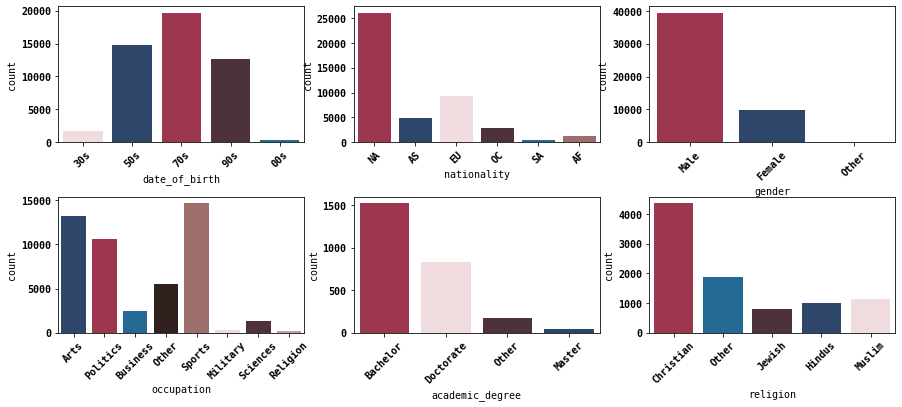

In [312]:
fig, ax = plt.subplots(2, 3,figsize=(15, 6))
fig.subplots_adjust(hspace=.4)
count = 0

# set color properties
palettes = [palette_generation, palette_continent, palette_gender, palette_occupation, palette_degree, palette_religion]
setProperties()

for row in range(2):
    for col in range(3):
        if ft_speaker[count] == 'date_of_birth':
            sns.countplot(data=df, x=ft_speaker[count], ax=ax[row, col], order=["30s","50s","70s","90s","00s"],palette=palettes[count])
        else:
            sns.countplot(data=df, x=ft_speaker[count], ax=ax[row, col], palette=palettes[count])
        ax[row,col].tick_params(axis='x', rotation=45)
        count += 1
plt.show()

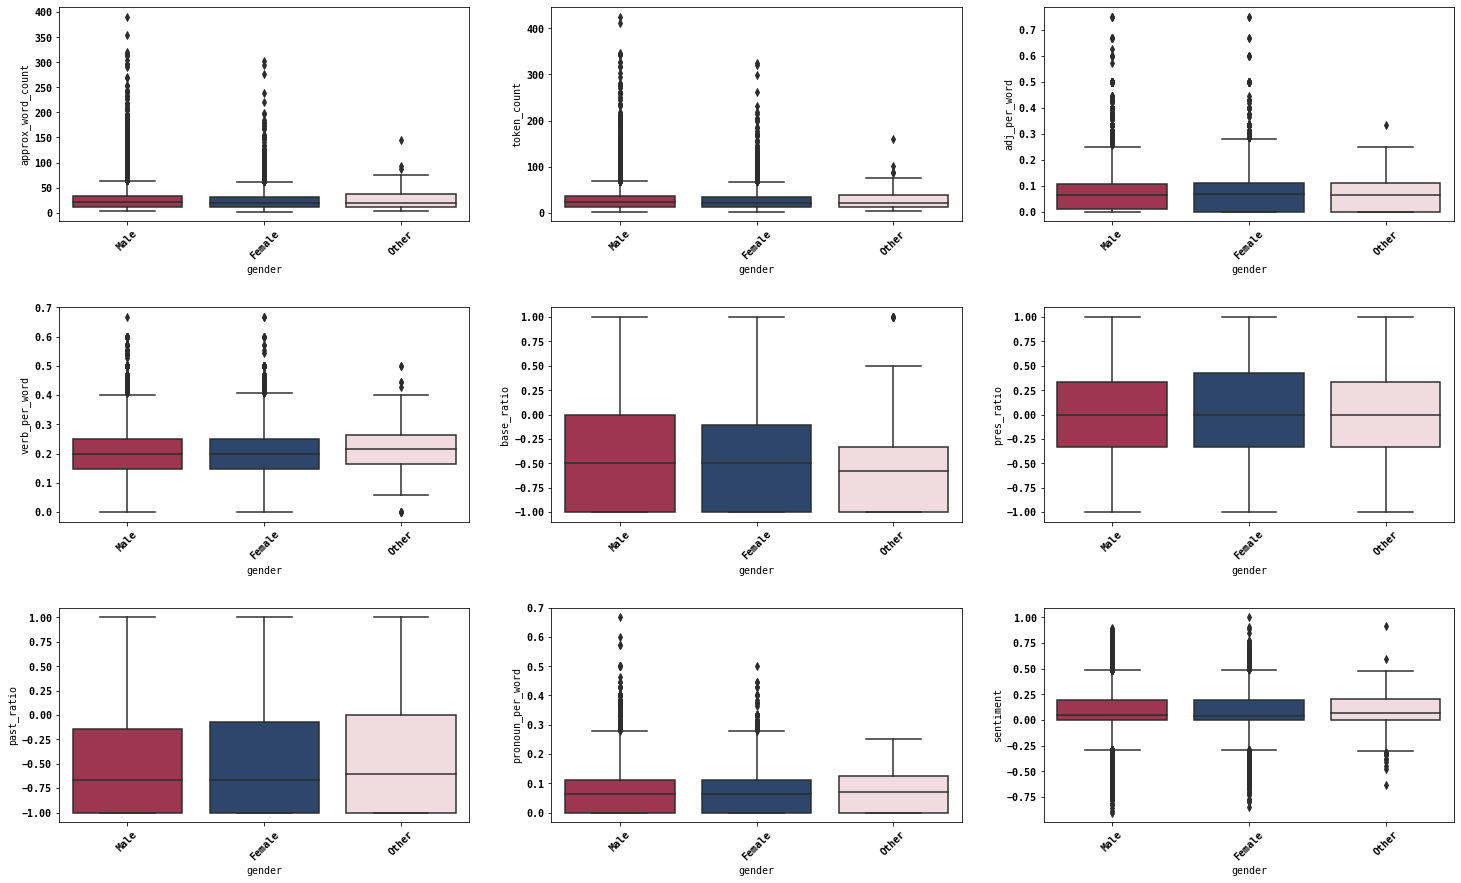

In [306]:
mean_boxplots(df, plot_by='gender', features=ft_visualize, palette = palette_gender)

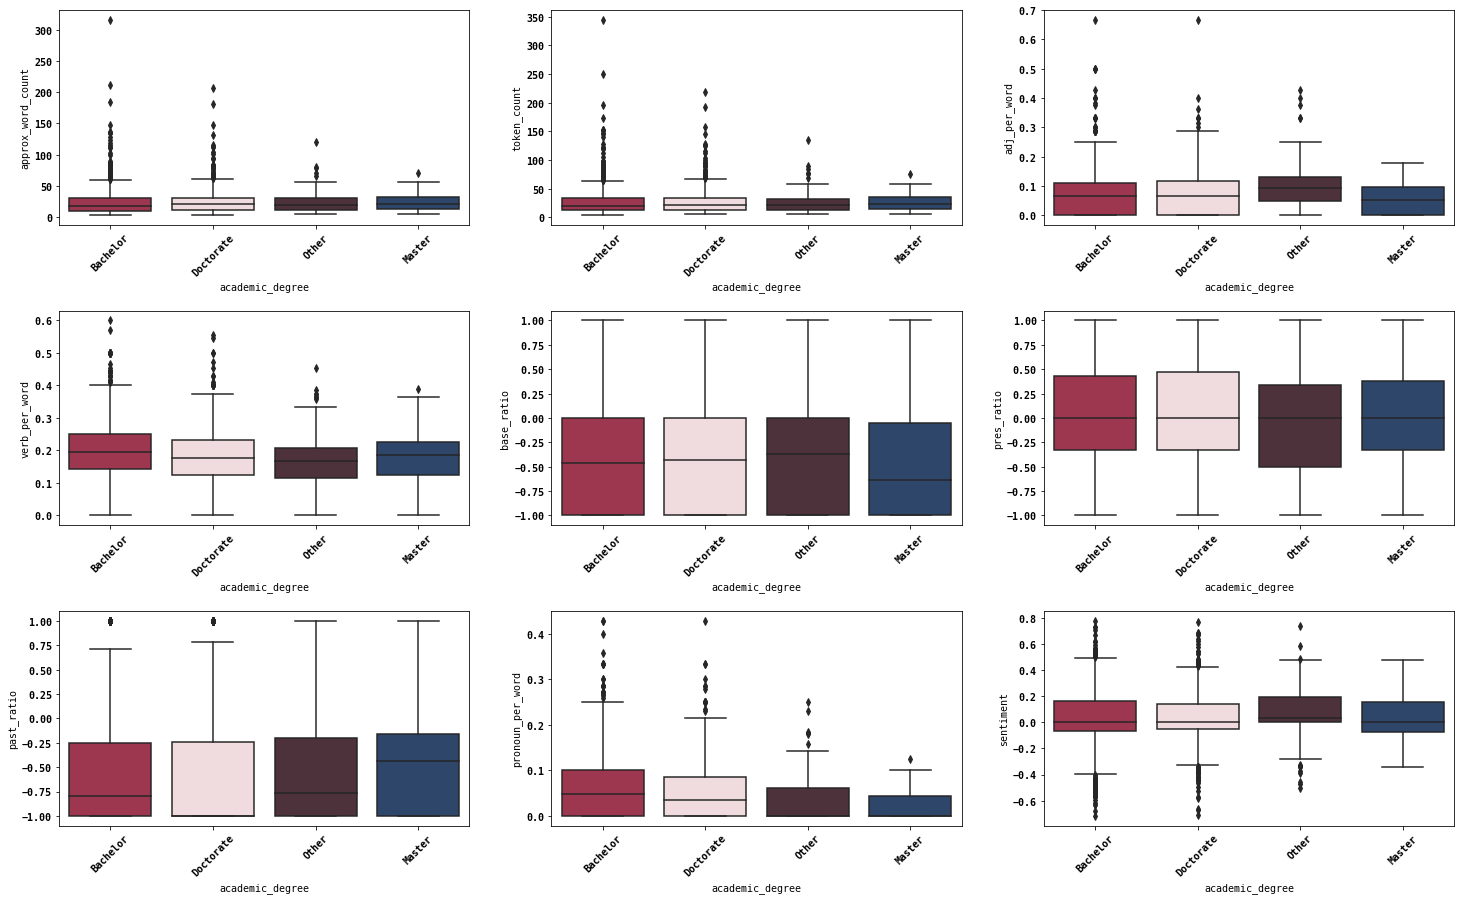

In [303]:
mean_boxplots(df, plot_by='academic_degree', features=ft_visualize, palette=palette_degree)

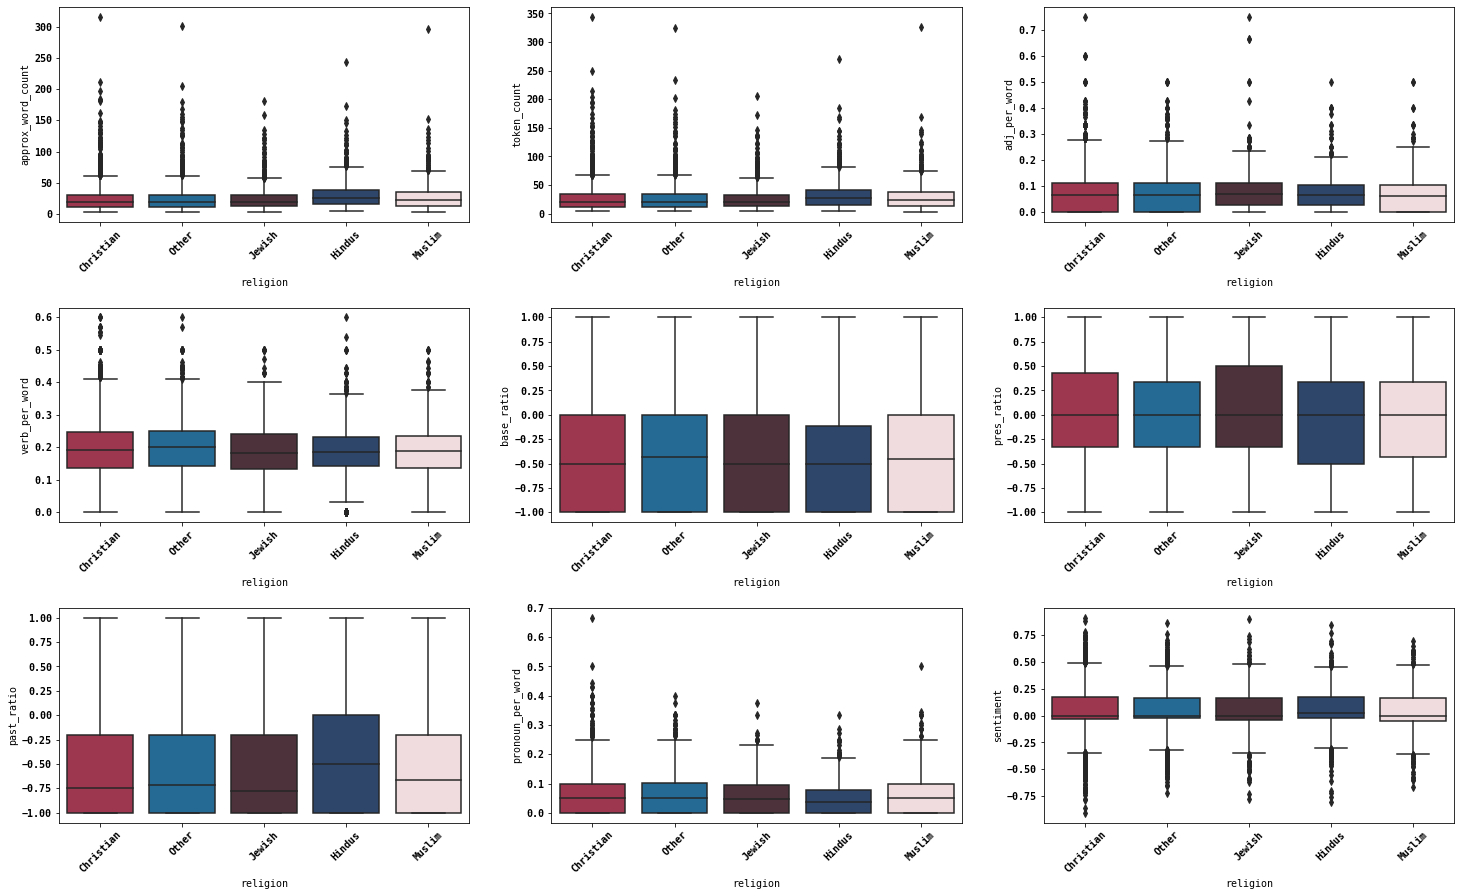

In [304]:
mean_boxplots(df, plot_by='religion', features=ft_visualize, palette=palette_religion)

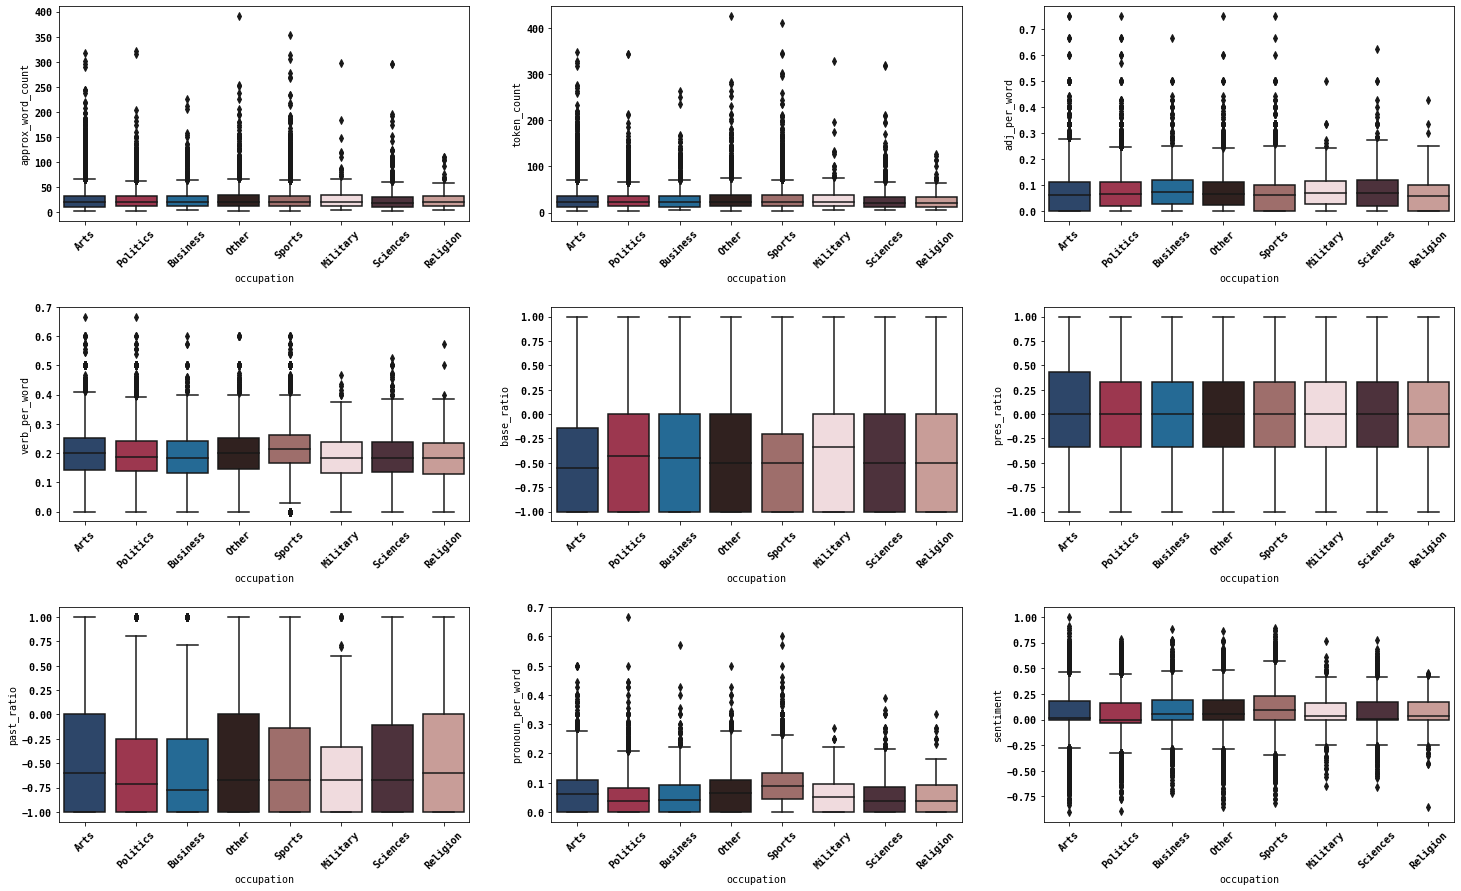

In [307]:
mean_boxplots(df, plot_by='occupation', features=ft_visualize, palette=palette_occupation)

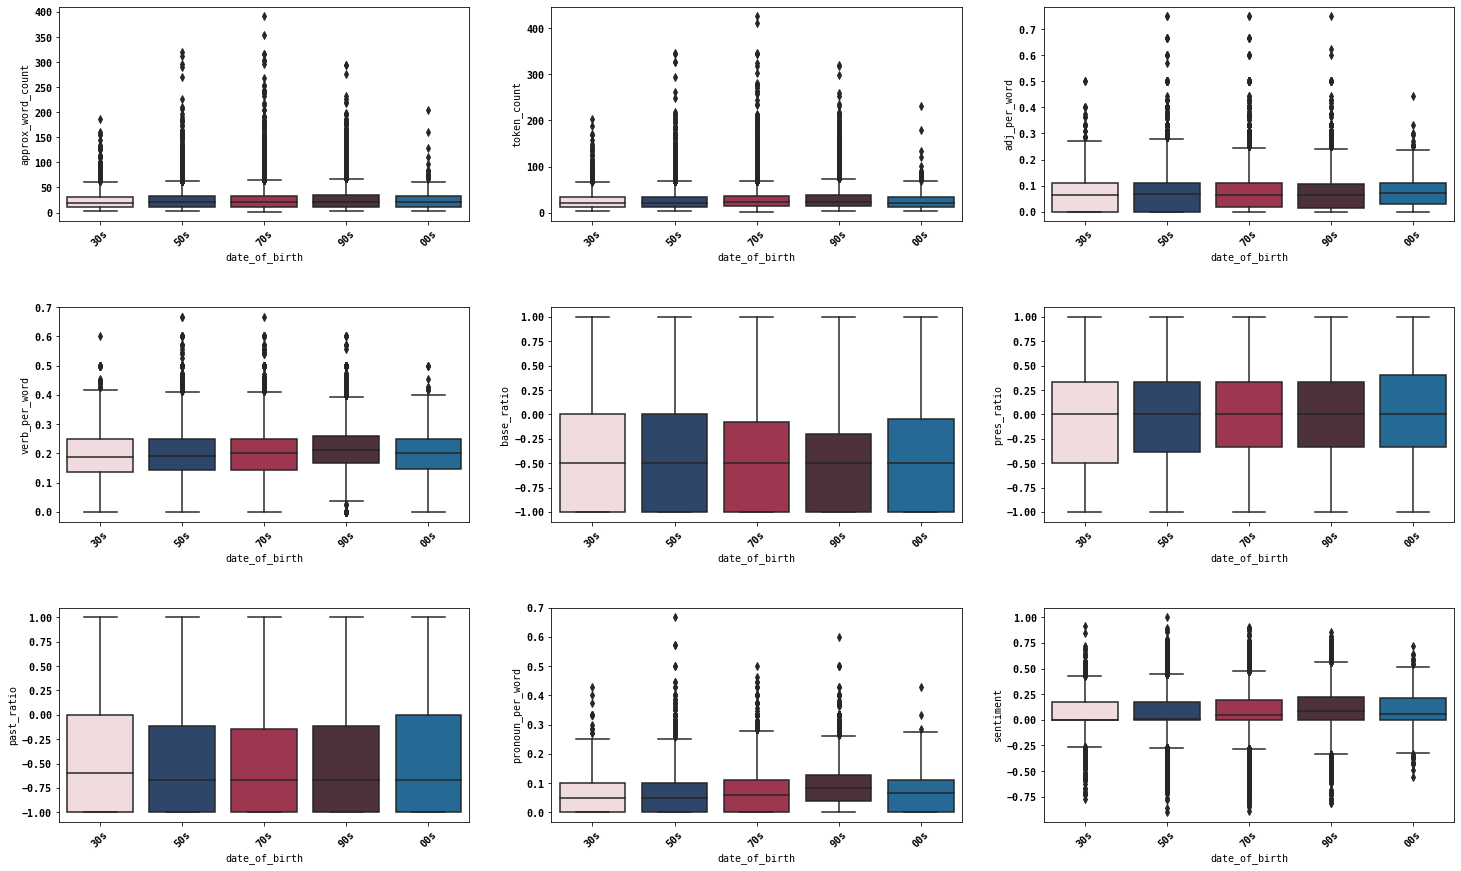

In [308]:
mean_boxplots(generations, plot_by='date_of_birth', features=ft_visualize, palette=palette_generation, order=["30s","50s","70s","90s","00s"])

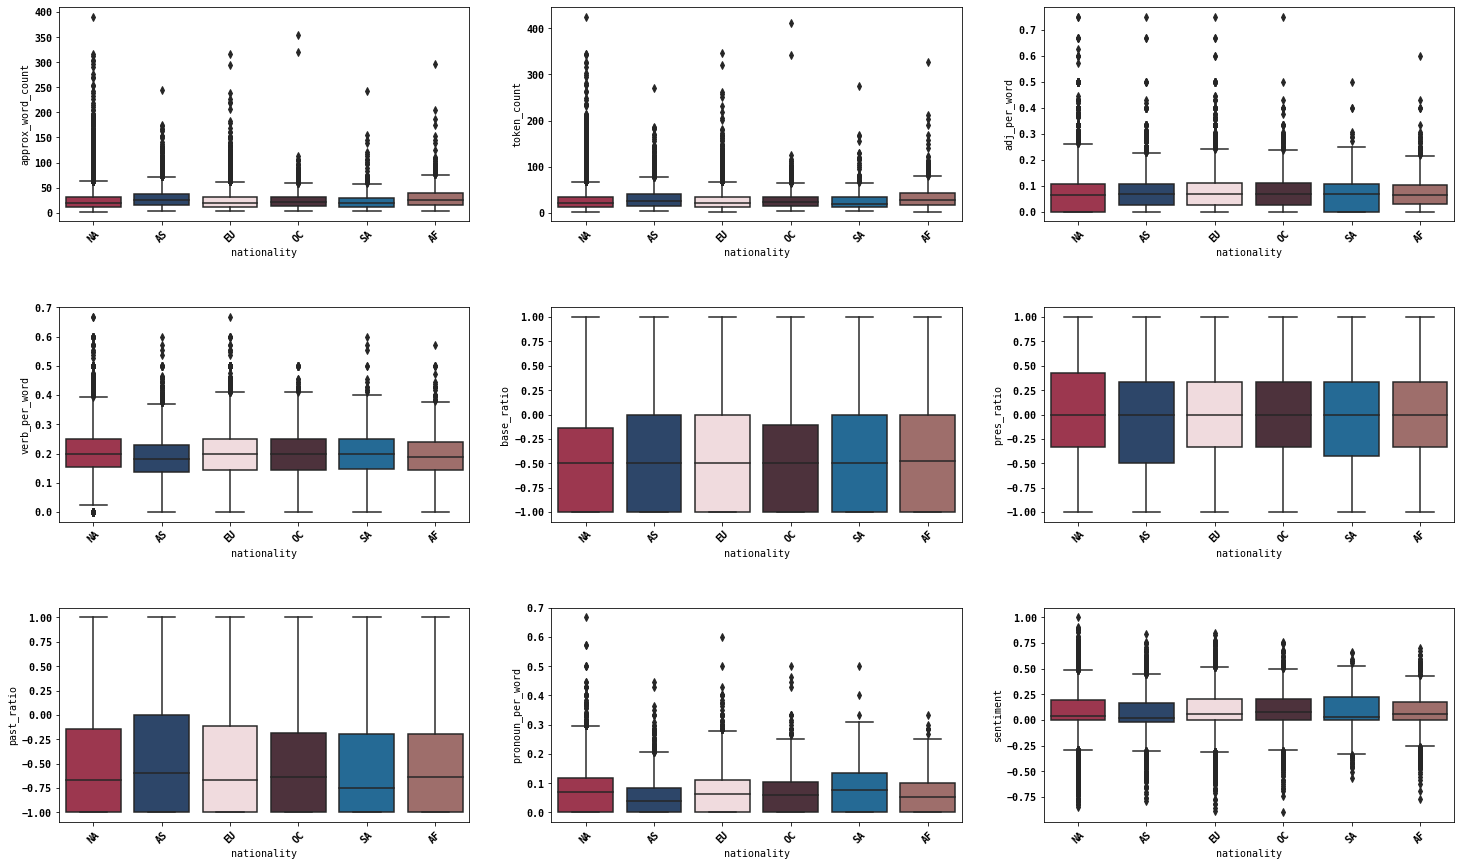

In [309]:
mean_boxplots(continents, plot_by='nationality', features=ft_visualize, palette=palette_continent)

## Tree-based feature selection

In [199]:
# use an extra-trees classifier to select most features with highest importance weights
for attribute in ft_speaker:
    clf, model, size, X, y = select_predictors(df, ft_language, attribute)
    print(attribute + 'input data size: ' + str(size))
    print('Selected lexical features are: ') 
    print(str(model.get_feature_names_out(ft_language)) + '\n')
    #print(clf.feature_importances_)

date_of_birthinput data size: (49235, 25)
Selected lexical features are: 
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']

nationalityinput data size: (45105, 25)
Selected lexical features are: 
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']

genderinput data size: (49235, 25)
Selected lexical features are: 
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']

occupationinput data size: (48489, 25)
Selected lexical features are: 
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']

academic_degreeinput

In [200]:
#We can see that the most significant features based on this selection are:
ft_selected = [',_per_sentence', 'sign_per_token', 'approx_word_count', 'token_count', 'adj_per_word', 'verb_per_word', 
               'base_ratio', 'pres_ratio', 'past_ratio', 'pronoun_per_word', 'sentiment']

## Significance testing

In [388]:
grid_mean, grid_max, significant_list, significant_p = test_significance(df, ft_language, ft_speaker, verbose=True)

The maximum statistically significant difference with sentence_count in date_of_birth is between 90s and 00s
The p-value is 5.3966158969910797e-79
The maximum statistically significant difference with ._per_sentence in date_of_birth is between 90s and 00s
The p-value is 6.63372719860907e-10
The maximum statistically significant difference with ,_per_sentence in date_of_birth is between 90s and 00s
The p-value is 0.0009880357605592737
The maximum statistically significant difference with !_per_sentence in date_of_birth is between 90s and 00s
The p-value is 4.8680359216449946e-17
The maximum statistically significant difference with ?_per_sentence in date_of_birth is between 90s and 00s
The p-value is 0.00818236944275147
The maximum statistically significant difference with :_per_sentence in date_of_birth is between 90s and 00s
The p-value is 0.0003375177058057862
The maximum statistically significant difference with ;_per_sentence in date_of_birth is between 90s and 00s
The p-value is 0

The maximum statistically significant difference with adj_per_word in gender is between Male and Female
The p-value is 0.252078161477188
The maximum statistically significant difference with ordinal_ratio in gender is between Male and Female
The p-value is 0.6884513374217884
The maximum statistically significant difference with comparative_ratio in gender is between Male and Female
The p-value is 0.345304992912738
The maximum statistically significant difference with superlative_ratio in gender is between Male and Female
The p-value is 0.31659363857679745
The maximum statistically significant difference with verb_per_word in gender is between Male and Female
The p-value is 0.9058381824744101
The maximum statistically significant difference with base_ratio in gender is between Male and Female
The p-value is 0.001049572783346566
The maximum statistically significant difference with pres_ratio in gender is between Male and Female
The p-value is 9.501863549875327e-05
The maximum statistica

The maximum statistically significant difference with past_ratio in academic_degree is between Doctorate and Master
The p-value is 0.05164317187034925
The maximum statistically significant difference with pronoun_per_word in academic_degree is between Doctorate and Master
The p-value is 0.0003673744955401548
The maximum statistically significant difference with self_ratio in academic_degree is between Doctorate and Master
The p-value is 0.38337768430284624
The maximum statistically significant difference with union_ratio in academic_degree is between Doctorate and Master
The p-value is 0.00025055363383832887
The maximum statistically significant difference with other_ratio in academic_degree is between Doctorate and Master
The p-value is 0.23251133036778193
The maximum statistically significant difference with sentiment in academic_degree is between Doctorate and Master
The p-value is 0.7709763801423776
The maximum statistically significant difference with sentence_count in religion is

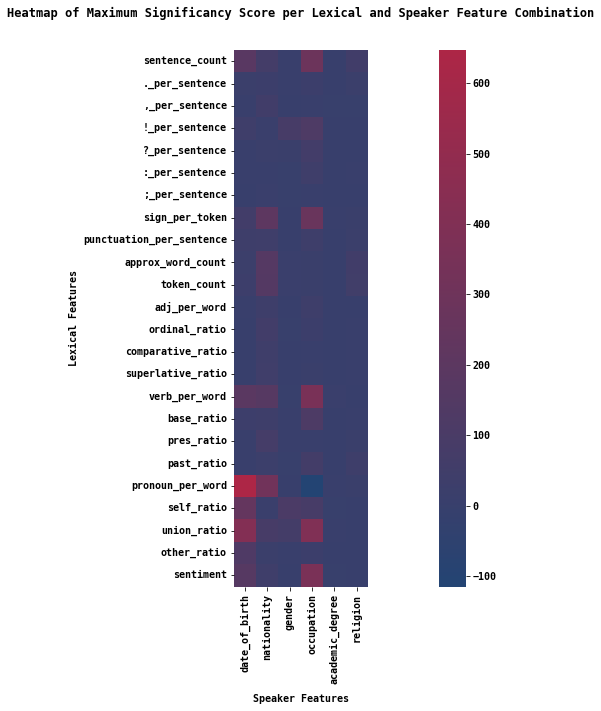

In [389]:
save_plot = False

df_grid_max = pd.DataFrame(data=np.log(grid_max), index=selected_feats, columns=speaker_feats)

fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
plt.title("Heatmap of Maximum Significancy Score per Lexical and Speaker Feature Combination", fontweight='semibold', y=1.05)
plot = sns.heatmap(df_grid_max, ax=ax, cmap=cmap, square=True)
plt.xlabel('Speaker Features', fontweight='semibold')
plt.ylabel('Lexical Features', fontweight='semibold')
ax.xaxis.set_label_coords(0.5, -0.2)
plt.tight_layout()
plt.show()
if save_plot:
    plot.get_figure().savefig("Max_Significancy_Score.png",dpi=300,bbox_inches="tight")

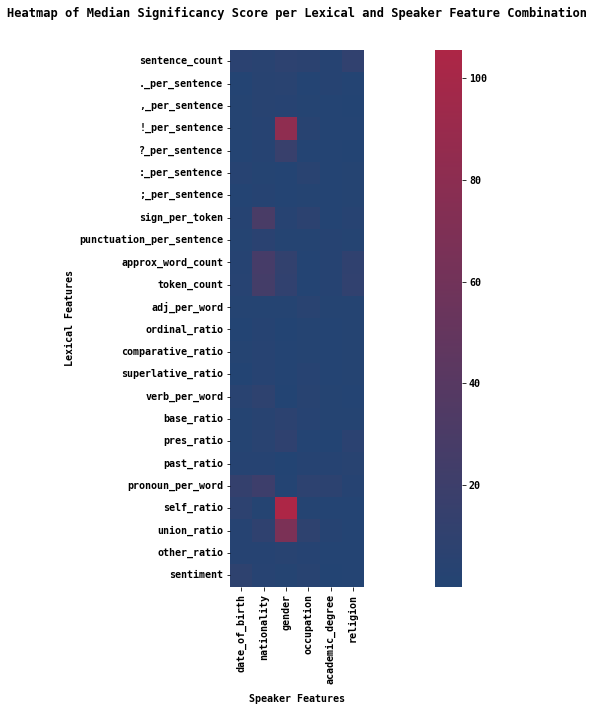

In [380]:
df_grid_mean = pd.DataFrame(data=np.log(grid_mean), index=selected_feats, columns=speaker_feats)

fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
plt.title("Heatmap of Median Significancy Score per Lexical and Speaker Feature Combination", fontweight='semibold',y=1.05)
plot = sns.heatmap(df_grid_mean, ax=ax, cmap=cmap, square=True)
plt.xlabel('Speaker Features', fontweight='semibold')
plt.ylabel('Lexical Features', fontweight='semibold')
ax.xaxis.set_label_coords(0.5, -0.2)
plt.tight_layout()
plt.show()
if save_plot:
    plot.get_figure().savefig("Median_Significancy_Score.png",dpi=300,bbox_inches="tight")

## Model fitting

In [224]:
# load balanced data
load_balanced_data = True # can load already balanced data instead of running all code again

if not load_balanced_data:
    df_occupation = get_balanced_sample('occupation', occupation_dict, sample_size=50)
    df_occupation.to_csv(join(dir_path, 'df_occupation_balanced.csv'))
    
    df_degree = get_balanced_sample('academic_degree', degree_dict, sample_size=50)
    df_degree.to_csv(join(dir_path,'df_degree_balanced.csv'))
    
    df_religion = get_balanced_sample('religion', religion_dict, sample_size=50)
    df_religion.to_csv(join(dir_path, 'df_religion_balanced.csv'))

else:
    filename = 'df_occupation_balanced.csv'
    df_occupation = pd.read_csv(join(dir_path, filename))

    filename = 'df_degree_balanced.csv'
    df_degree = pd.read_csv(join(dir_path, filename))

    filename = 'df_religion_balanced.csv'
    df_religion = pd.read_csv(join(dir_path, filename))

# balance gender data directly with existing sample
male_indices = df[df.gender == 'Male'].index
sample_size = sum(df.gender == 'Female')
random_indices = np.random.choice(male_indices, sample_size, replace=False)
male_samples = df.loc[random_indices]
df_gender = pd.concat([df[df.gender == 'Female'], male_samples])

# unbalanced datasets 
df_generation = df.dropna(subset=['date_of_birth'])

df_continent = df.dropna(subset=['nationality'])

### Use selected features

In [338]:
dicts = [generation_dict, continent_dict, gender_dict, occupation_dict, degree_dict, religion_dict]
df_list = [df_generation, df_continent, df_gender, df_occupation, df_degree, df_religion]

for i in range(len(ft_speaker)):
    temp = df_list[i]
    
    # transform original data to keep only most important lexical features
    X = temp[ft_selected].to_numpy()
    y = temp[ft_speaker[i]].map(dicts[i]).to_numpy()
    
    # training with 70/30 split of gradient bossting regressor
    reg, r2 = train_GBR_model(X, y)
    print('R2-score for {} is: {:.4f}'.format(ft_speaker[i], r2))

R2-score for date_of_birth is: 0.0246
R2-score for nationality is: 0.0194
R2-score for gender is: -0.0022
R2-score for occupation is: 0.0096
R2-score for academic_degree is: 0.0117
R2-score for religion is: 0.0013


### Using statistically interesting features

In [342]:
# fit model to specific lexical features that were found to be statistically signifant to the predictor
ft_gender = ['!_per_sentence', 'punctuation_per_sentence', 'self_ratio', 'union_ratio']
ft_occupation = ['sentence_count', '!_per_sentence', 'sign_per_token', 'verb_per_word', 'pronoun_per_word', 'union_ratio', 'sentiment']
stat_sig_attributes = ['gender', 'occupation']

for i in range(len(ft_speaker)):
    temp = df_list[i]
    
    if ft_speaker[i] in stat_sig_attributes:
        if ft_speaker[i] == 'gender':
            features = ft_gender
            
        if ft_speaker[i] == 'occupation':
            features = ft_occupation
            
        # transform original data to keep only most important lexical features
        X = temp[features].to_numpy()
        y = temp[ft_speaker[i]].map(dicts[i]).to_numpy()

        # training with 70/30 split of gradient bossting regressor
        reg, r2 = train_GBR_model(X, y)
        print('R2-score with statistically interesting features for {} is: {:.4f}'.format(ft_speaker[i], r2))

R2-score with statistically interesting features for gender is: 0.0106
R2-score with statistically interesting features for occupation is: 0.0092


## Feature agglomeration

Was not used because it is difficult to understand the meaning of combined language features.

In [343]:
X = df[ft_language].copy().to_numpy()
X.shape

(49235, 24)

In [344]:
agglo = cluster.FeatureAgglomeration(n_clusters=None, distance_threshold=120)
agglo.fit(X)
X_reduced = agglo.transform(X)
X_reduced.shape

(49235, 14)

In [345]:
df_agglo = pd.DataFrame(X_reduced)
df_agglo.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.000000,0.075781,1.0,0.00,-1.0,0.666667,1.000000,22.0,0.00,0.0,-1.000000,1.0,-0.666667,21.0
1,-1.000000,0.024857,0.0,0.00,0.0,1.000000,1.000000,8.0,0.00,1.0,-1.000000,1.0,-1.000000,7.0
2,-0.923077,0.053290,1.0,0.75,-1.0,-0.357143,0.846154,160.0,-0.75,1.2,-0.571429,5.0,-0.071429,149.0
3,0.000000,0.034392,1.0,0.00,0.0,1.000000,0.000000,14.0,0.00,1.0,-1.000000,1.0,-1.000000,12.0
4,0.000000,0.096296,0.0,0.00,0.0,1.000000,0.000000,6.0,0.00,1.0,-1.000000,1.0,-1.000000,5.0


## Detailed dive into distributions

In [400]:
def plot_distribution(sample, lexical, speaker, binwidth, include_only=[]):
    if include_only is None:
        ax = sns.kdeplot(x=lexical,hue=speaker,common_norm=False, data=sample, cut=0)
    else:
        tmp = sample[sample[speaker].isin(include_only)]
        ax = sns.kdeplot(x=lexical,hue=speaker,common_norm=False, data=tmp, cut=0)
    ax.yaxis.set_major_formatter(PercentFormatter(1/binwidth))
    plt.ylabel("Probability", fontweight='semibold')
    plt.xlabel(ax.get_xlabel(), fontweight='semibold')
    plt.show()
    ax.get_figure().savefig("Distribution_{}_with_{}_and_{}.png".format(speaker,include_only[0], include_only[1]),dpi=300,bbox_inches="tight")
    
def get_most_significant(Significant_list,Significant_p,rank):
    return Significant_list[:rank], Significant_p[:rank]

def get_least_significant(Significant_list,Significant_p,rank):
    return Significant_list[-rank:], Significant_p[-rank:]

In [395]:
most_significant_list, p_list = get_most_significant(significant_list, significant_p, 4)
least_significant_list, p_list = get_least_significant(significant_list, significant_p, 5)

In [396]:
most_significant_list

[['Politics', 'Sports', 'pronoun_per_word', 'occupation'],
 ['50s', '90s', 'pronoun_per_word', 'date_of_birth'],
 ['50s', '90s', 'union_ratio', 'date_of_birth'],
 ['Arts', 'Politics', 'union_ratio', 'occupation']]

In [397]:
least_significant_list

[['NA', 'AS', '?_per_sentence', 'nationality'],
 ['Christian', 'Hindus', '!_per_sentence', 'religion'],
 ['EU', 'SA', 'self_ratio', 'nationality'],
 ['Politics', 'Sciences', 'comparative_ratio', 'occupation'],
 ['Politics', 'Religion', 'pres_ratio', 'occupation']]

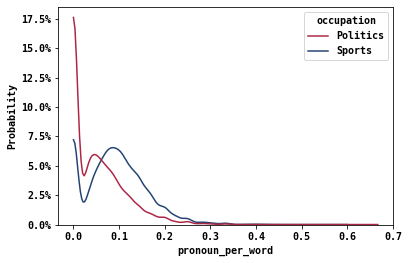

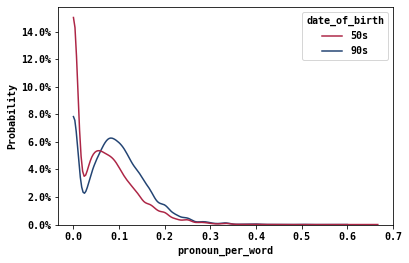

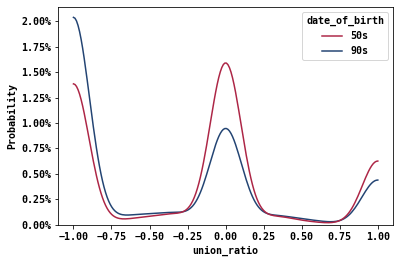

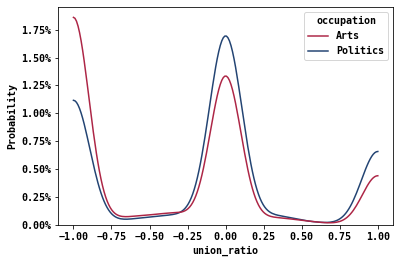

In [398]:
for significant_list in most_significant_list:
    plot_distribution(df, significant_list[2], significant_list[3], binwidth=0.01, include_only=significant_list[:2])

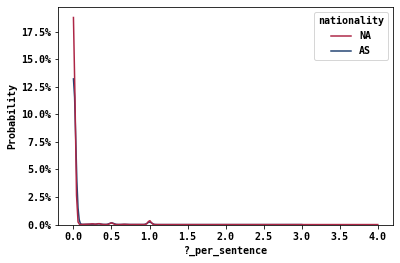

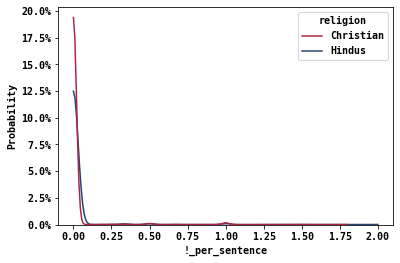

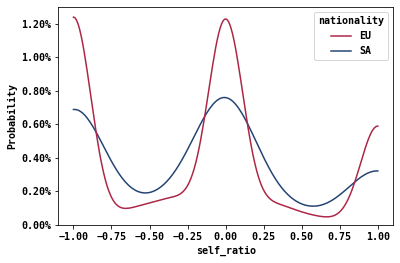

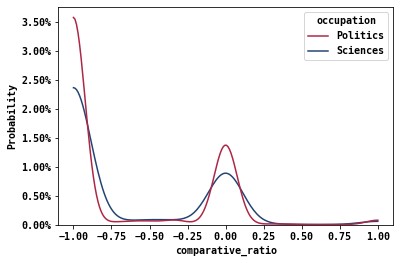

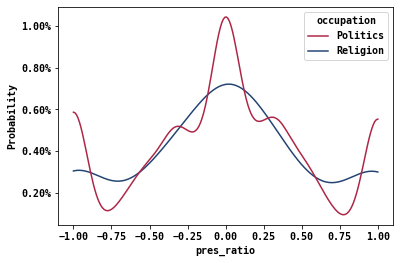

In [401]:
for significant_list in least_significant_list:
    plot_distribution(df, significant_list[2], significant_list[3], binwidth=0.01, include_only=significant_list[:2])